## Irradiance profiling

In [1]:
cd G:\My Drive\1_Work\1 Racer_project\Code_Model_simulation\modifed_9600_feeder_Aug_2024\Loadshapes

G:\My Drive\1_Work\1 Racer_project\Code_Model_simulation\modifed_9600_feeder_Aug_2024\Loadshapes


NaN values in data: 0
X shape: (553, 168, 4), y shape: (553, 24)
X_train shape: (442, 168, 4), y_train shape: (442, 24, 1)
X_test shape: (111, 168, 4), y_test shape: (111, 24, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 repeat_vector (RepeatVector  (None, 24, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 time_distributed (TimeDistr  (None, 24, 1)            65        
 ibuted)                                                         
                                                                 
Total par

NameError: name 'test_df' is not defined

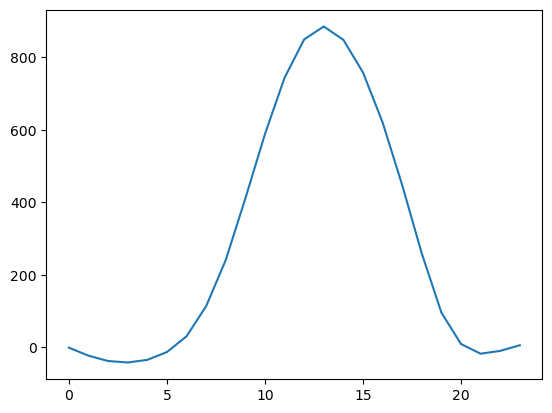

In [2]:
## Irradiance forecasting with pst seven days sorarradiation, temp, humidity, and cloudcover data

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

file = "Maui Meadows_2017-05-01_to_2017-05-31.csv"
df_long = pd.read_csv(file)
df_long['datetime'] = pd.to_datetime(df_long['datetime'])
df_selected = df_long[['datetime', 'temp', 'humidity', 'cloudcover', 'solarradiation']].copy()
df_selected.loc[:, "solarradiation"] = df_selected["solarradiation"].clip(upper=1000)
df_selected = df_selected.sort_values('datetime')

features = ['temp', 'humidity', 'cloudcover', 'solarradiation']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_selected[features])

print(f"NaN values in data: {np.isnan(scaled_data).sum()}")

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out, -1])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 24*7, 24 
X, y = create_sequences(scaled_data, n_steps_in, n_steps_out)

print(f"X shape: {X.shape}, y shape: {y.shape}")

y = y.reshape((y.shape[0], y.shape[1], 1))


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

model = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps_in, len(features))),
    RepeatVector(n_steps_out),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', run_eagerly=True)
model.summary()

try:
    test_pred = model.predict(X_train[:1])
    print(f"Test prediction shape: {test_pred.shape}")
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        verbose=1
    )
except Exception as e:
    print(f"Error during training: {str(e)}")
    print("Troubleshooting steps:")
    print("1. Verify input/output shapes match model expectations")
    print("2. Check for NaN/infinite values in data")
    print("3. Try reducing model complexity")
    print("4. Verify your TensorFlow/Keras version")
    

## Forecasted data and processing from previous modeling multi-feature data
y_pred = model.predict(X_test)
last_sequence = scaled_data[-n_steps_in:]
last_sequence = last_sequence.reshape(1, n_steps_in, len(features))
forecast = model.predict(last_sequence)
def inverse_scale_forecast(forecast, scaler, n_features=4):
    """Inverse transform the forecasted solar radiation values."""
    dummy = np.zeros((forecast.shape[0], forecast.shape[1], n_features))
    dummy[:, :, -1] = forecast.squeeze()  
    dummy = dummy.reshape(-1, n_features)
    inverted = scaler.inverse_transform(dummy)[:, -1]
    return inverted.reshape(forecast.shape[0], forecast.shape[1])

y_pred_inv = inverse_scale_forecast(y_pred, scaler)
forecast_inv = inverse_scale_forecast(forecast, scaler)

fore_df = pd.DataFrame({"forecast_irradiance": forecast_inv[0]})
fore_df.to_csv("forecast_irradiance.csv", header=None, index=None)
import matplotlib.pyplot as plt
import numpy as np

x_axis = np.arange(24)
plt.plot(forecast_inv[0])
plt.plot(x_axis, test_df["solarradiation"].iloc[(24*7):(24*8)].values)

## time resolution interpolation from the forecasted irradiance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def normalization(data_path):
    df = pd.read_csv(data_path, header=None)
    normalized_data = (df - df.min()) / (df.max() - df.min())
    return normalized_data

def interpolate_time_series(csv_path, input_resolution, output_resolution, total_time=24):
    df = pd.read_csv(csv_path, header=None)
    input_data = df.iloc[:, 0].values  
#     print(input_data)
    input_points = int(60/input_resolution) * total_time
    output_points = int(60/output_resolution) * total_time

    time_input = np.linspace(0, total_time, input_points)
    time_output = np.linspace(0, total_time, output_points)

    interp_func = interp1d(time_input, input_data, kind='linear', fill_value="extrapolate")

    output_data = interp_func(time_output)

    plt.figure(figsize=(10, 5))
    plt.plot(time_input, input_data, 'o-', label=f"Original {input_resolution}-min Data")
    plt.plot(time_output, output_data, '--', label=f"Interpolated {output_resolution}-min Data")

    plt.xlabel("Time (hours)")
    plt.ylabel("Load Shape")
    plt.title(f"{input_resolution}-min vs {output_resolution}-min Interpolation")
    plt.legend()
    plt.grid()
    plt.show()
    
    return output_data

input_file = "forecast_irradiance.csv"
total_time=24
input_resolution = 60  # Set your input time resolution (e.g., 60 minutes for hourly data)
output_resolution = 15  # Set your desired output time resolution (e.g., 15 minutes)
interpolated_data = interpolate_time_series(input_file, input_resolution, output_resolution, total_time)

# output_file ="forecasted_1_day_15m_interval_irradiance.csv"

# pd.DataFrame(interpolated_data).to_csv(output_file, index=None, header=None)

## STGNN model

In [1]:
cd G:\My Drive\1_Work\1 Racer_project\code_sharing_Shishir

G:\My Drive\1_Work\1 Racer_project\code_sharing_Shishir


In [17]:
## PV estimation Algorithm Using STGNN

## Import necessary packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler

def load_data():
    location_data = pd.read_csv("satellite_data_static_2.csv")
    observed_location = location_data[location_data["is_proxy_pv"] == 1][["latitude", "longitude"]].values
    unobserved_location = location_data[location_data["is_proxy_pv"] == 0][["latitude", "longitude"]].values

    irradiance_data = pd.read_csv("proxy_1_day_15m_interval_irrad.csv", header=None)
    # irradiance_data["time"] = pd.to_datetime(irradiance_data["time"])
    # irradiance_data.set_index("time", inplace=True)

    power_data = pd.read_csv("proxy_pv_1003.csv", header=None)  # Observed PV data in kW
    # power_data["time"] = pd.to_datetime(power_data["time"])
    # power_data.set_index("time", inplace=True)

    return observed_location, unobserved_location, irradiance_data, power_data

observed_location, unobserved_location, irradiance_data, power_data = load_data()

class STGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(STGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_weight):
        print(f"Initial x shape: {x.shape}")
        x = self.gcn1(x, edge_index, edge_weight)
        print(f"After GCN1 x shape: {x.shape}")
        x = torch.relu(x)
        x = self.gcn2(x, edge_index, edge_weight)
        print(f"After GCN2 x shape: {x.shape}")
        x = torch.relu(x)
#         x = x.unsqueeze(0)
        if x.dim() == 2:     #to make x 3-D for proper channeling: (batch_size, sequence_length, input_size)
            x = x.unsqueeze(0)
        print(f"After unsqueeze x shape: {x.shape}")
        x, _ = self.lstm(x)
        print(f"After LSTM x shape: {x.shape}")
        x = x.squeeze(0)
        print(f"After squeeze x shape: {x.shape}")
        x = self.fc(x)
        print(f"After FC x shape: {x.shape}")
        return x

def train_model(data, epochs=100, lr=0.01):
    model = STGNN(input_dim=data.x.shape[1], hidden_dim=32, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        loss = criterion(out, data.x[:, 1].unsqueeze(1))  # loss constraint
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model

def estimate_power_generation(model, data, scaler_power, max_pv_unobserved):
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index, data.edge_attr)
        predictions = scaler_power.inverse_transform(predictions.numpy())  # Rescale to original units
        predictions = predictions * (max_pv_unobserved / scaler_power.data_max_)  # Scale based on known max PV output
        # if the panel efficiency, tilt_angle, and shading_factors of the BTM-PV are known?
#         predictions = predictions * panel_efficiency * np.cos(np.radians(tilt_angle)) * shading_factor
    return predictions

## There are two sets of code for distance matrix generation...
## One uses latitude and longitude based coordinates and another uses unitless coordinates
## haversine distance matrix is efficient for longitude & latitude based distances whereas euclidean works better with unitless
## For our experiment, we have chosen euclidean, as the coordinates in IEEE-9600 Node model are unitless

## for latitude and longitude based coordinates
# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371  # Earth radius in km
#     dlat = np.radians(lat2 - lat1)
#     dlon = np.radians(lon2 - lon1)
#     a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#     return R * c
# distance = haversine(observed_location[0][0], observed_location[0][1],
#                      unobserved_location[0][0], unobserved_location[0][1])

## for unitless coordinates
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

distance = euclidean_distance(observed_location[0][0], observed_location[0][1],
                              unobserved_location[0][0], unobserved_location[0][1])


scaler_irradiance = MinMaxScaler()
scaler_power = MinMaxScaler()
rated_p = 5  # Rated P in kW of BTM PV
irradiance_data_scaled = scaler_irradiance.fit_transform(irradiance_data.values.reshape(-1, 1))
power_data_scaled = scaler_power.fit_transform(power_data.values.reshape(-1, 1))

edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)
edge_weight = torch.tensor([1.0 / distance, 1.0 / distance], dtype=torch.float)

features = np.hstack((irradiance_data_scaled, power_data_scaled))
features = torch.tensor(features, dtype=torch.float)

data = Data(x=features, edge_index=edge_index.t().contiguous(), edge_attr=edge_weight)

model = train_model(data)

predictions = estimate_power_generation(model, data, scaler_power, rated_p)

predictions_df = pd.DataFrame(predictions, index=irradiance_data.index, columns=["estimated_power_generation"])
predictions_df.to_csv("estimated_power_generation_testing_1_day_15_min.csv")

Initial x shape: torch.Size([96, 2])
After GCN1 x shape: torch.Size([96, 32])
After GCN2 x shape: torch.Size([96, 32])
After unsqueeze x shape: torch.Size([1, 96, 32])
After LSTM x shape: torch.Size([1, 96, 32])
After squeeze x shape: torch.Size([96, 32])
After FC x shape: torch.Size([96, 1])
Epoch 0, Loss: 0.2608760893344879
Initial x shape: torch.Size([96, 2])
After GCN1 x shape: torch.Size([96, 32])
After GCN2 x shape: torch.Size([96, 32])
After unsqueeze x shape: torch.Size([1, 96, 32])
After LSTM x shape: torch.Size([1, 96, 32])
After squeeze x shape: torch.Size([96, 32])
After FC x shape: torch.Size([96, 1])
Initial x shape: torch.Size([96, 2])
After GCN1 x shape: torch.Size([96, 32])
After GCN2 x shape: torch.Size([96, 32])
After unsqueeze x shape: torch.Size([1, 96, 32])
After LSTM x shape: torch.Size([1, 96, 32])
After squeeze x shape: torch.Size([96, 32])
After FC x shape: torch.Size([96, 1])
Initial x shape: torch.Size([96, 2])
After GCN1 x shape: torch.Size([96, 32])
After 

## Load Forecasting

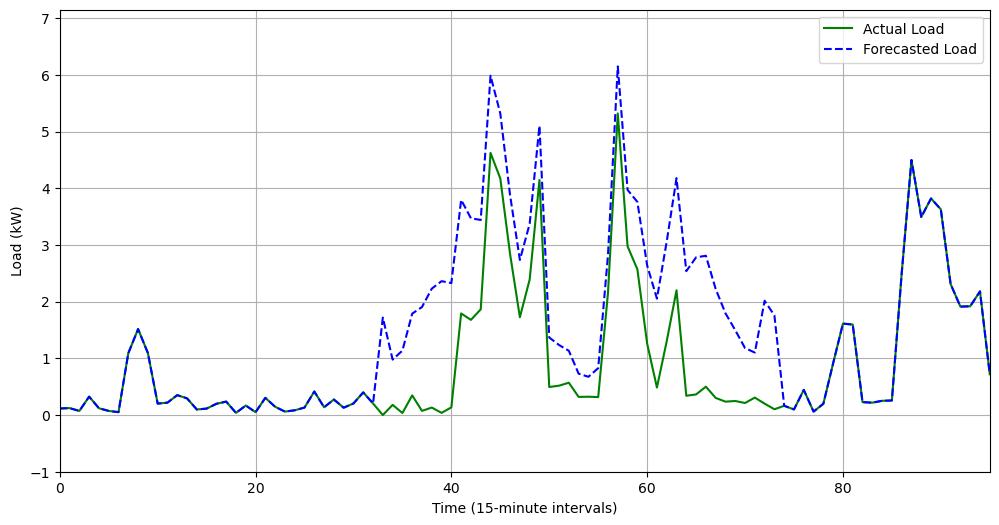

In [65]:
## PV Forecasting in 15-min ahead Algorithm

import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# scaler_irradiance = MinMaxScaler()
# scaler_power = MinMaxScaler()
rated_p = 6.0  # kW   (unobserved PV rating)
scaler_power = MinMaxScaler(feature_range=(0,1))
scaler_power.fit(np.array([[0],[rated_p]]))  # force 0 → 0, 5 kW → 1
power_data_scaled = scaler_power.transform(power_data.values.reshape(-1,1))


forecasted_irradiance = pd.read_csv("forecasted_1_day_15m_interval_irradiance.csv", header=None)
forecasted_irradiance = forecasted_irradiance.values.reshape(-1, 1)
historical_power = pd.read_csv("estimated_power_generation_testing_1_day_15_min.csv")
historical_power = historical_power["estimated_power_generation"].values.reshape(-1, 1)
forecasted_irradiance_scaled = scaler_irradiance.transform(forecasted_irradiance)
historical_power_scaled = scaler_power.transform(historical_power)
input_data = np.hstack((forecasted_irradiance_scaled, historical_power_scaled))
input_data_scaled = torch.tensor(input_data, dtype=torch.float).unsqueeze(0)
def iterative_15_min_forecast(model, initial_input, edge_index, edge_attr, scaler_power, max_pv_unobserved, forecast_horizon):
    model.eval()
    forecasts = []
    current_input = initial_input.clone()

    for i in range(forecast_horizon):
        with torch.no_grad():
            prediction = model(current_input, edge_index, edge_attr)
            # print(prediction)
            prediction = scaler_power.inverse_transform(prediction.numpy())
            # prediction = prediction * (max_pv_unobserved / scaler_power.data_max_[0])
            prediction = np.clip(prediction, 0, max_pv_unobserved)
            # Set PV generation to zero if irradiance is below threshold (nighttime)
            if forecasted_irradiance[i][0] <= 200:
                prediction[0][0] = 0
            forecasts.append(prediction[0][0])
            new_input = torch.tensor([[forecasted_irradiance_scaled[i][0], prediction[0][0]]], dtype=torch.float)
            new_input = new_input.unsqueeze(0)
            current_input = torch.cat((current_input[:, 1:, :], new_input), dim=1)
    return forecasts

# iterative 15-minute ahead forecasting
pv_rating = 5  # P rating of BTM PV
forecast_horizon = 96 
forecasts = iterative_15_min_forecast(model, input_data_scaled, data.edge_index, data.edge_attr, scaler_power, pv_rating, forecast_horizon)

forecast_df = pd.DataFrame(forecasts, columns=["forecasted_power_generation"])
forecast_df.to_csv("15_min_forecasts.csv", index=False)
# original pv data for comparison
# actual_df = pd.read_csv("btm_pv_1001.csv", header=None)
# actual_power = actual_df.values * (-1)
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(actual_power, label="Actual PV Power", color="green")
# forecast_line, = ax.plot([], [], label="Forecasted PV Power", color="blue", linestyle="--")

# forecasted load and actual load

actual_df_load  = pd.read_csv("Test9500new_Mon_service_trans_pv_1001_1.csv")
forecasted_load = (
    forecast_df["forecasted_power_generation"].values
    - actual_df_load["total_P"].values
)
pd.DataFrame(forecasted_load, columns=["forecasted_load"]).to_csv(
    "15_min_load_forecasts.csv", index=False
)

actual_load = actual_df_load["total_load"].values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(actual_load, label="Actual Load", color="green")
forecast_line, = ax.plot([], [], label="Forecasted Load", color="blue", linestyle="--")
y_min = min(np.min(actual_load), np.min(forecasted_load))
y_max = max(np.max(actual_load), np.max(forecasted_load))
ax.set_ylim(y_min - 1, y_max + 1)
ax.set_xlim(0, len(actual_load) - 1)

ax.set_xlabel("Time (15‑minute intervals)")
ax.set_ylabel("Load (kW)")
ax.legend()
ax.grid(True)

def update(frame):
    forecast_line.set_data(range(frame + 1), forecasted_load[:frame + 1])
    return forecast_line,

ani = animation.FuncAnimation(
    fig, update, frames=len(forecasted_load), interval=100, blit=True
)
ani.save("forecast_load_animation.mp4", writer="ffmpeg", fps=10)
plt.show()